In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split  
from sklearn.metrics import confusion_matrix, accuracy_score

In [2]:
df = pd.read_csv("health_data.csv")
df.tail()

,sleep_hours,exercise_minutes,screen_time_hours,water_glasses,fast_food_per_week
495,9.834798,89.227070,12.371965,4.213727,3.227368
496,9.535354,131.799146,7.568516,0.234177,6.417110
497,9.630956,38.190113,13.988895,4.440694,6.545118
498,9.808537,114.928255,9.727284,2.343983,4.747361
499,9.190211,141.151990,13.336419,4.619925,4.804938


In [3]:
def label_row(r):
    cond = (
        (7 <= r["sleep_hours"] <= 8)
        and (r["exercise_minutes"] >= 90)
        and (r["screen_time_hours"] <= 8)
        and (r["water_glasses"] >= 5)
        and (r["fast_food_per_week"] <= 3)
    )
    return 1 if cond else 0

df["healthy"] = df.apply(label_row, axis=1)

print("Distribution des classes:\n", df["healthy"].value_counts(normalize=True))

df.head()

Distribution des classes:
 healthy
0    0.806
1    0.194
Name: proportion, dtype: float64


,sleep_hours,exercise_minutes,screen_time_hours,water_glasses,fast_food_per_week,healthy
0,7.834044,289.536985,7.756606,9.721948,2.665159,1
1,8.440649,206.897170,6.823765,10.598436,0.553153,0
2,7.000229,282.277333,2.193938,5.563707,1.756045,1
3,7.604665,224.728904,6.256324,6.621916,2.694615,1
4,7.293512,171.901620,4.790009,6.453380,1.338352,1


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   sleep_hours         500 non-null    float64
 1   exercise_minutes    500 non-null    float64
 2   screen_time_hours   500 non-null    float64
 3   water_glasses       500 non-null    float64
 4   fast_food_per_week  500 non-null    float64
 5   healthy             500 non-null    int64  
dtypes: float64(5), int64(1)
memory usage: 23.6 KB


In [5]:
df.describe()

,sleep_hours,exercise_minutes,screen_time_hours,water_glasses,fast_food_per_week,healthy
count,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000
mean,7.557369,126.663786,8.448126,5.735642,4.122001,0.194000
std,1.868988,79.845168,3.460793,3.118636,2.838441,0.395825
min,4.014638,0.797480,2.018108,0.020060,0.041303,0.000000
25%,5.688532,62.288944,5.767135,3.362114,1.714352,0.000000
50%,8.060223,120.113926,8.409272,5.875461,3.315868,0.000000
75%,9.270155,180.531953,11.448547,7.855903,6.552109,0.000000
max,9.993431,298.721735,13.988895,11.925380,9.988793,1.000000


In [6]:
df.isnull().sum()

sleep_hours           0
exercise_minutes      0
screen_time_hours     0
water_glasses         0
fast_food_per_week    0
healthy               0
dtype: int64

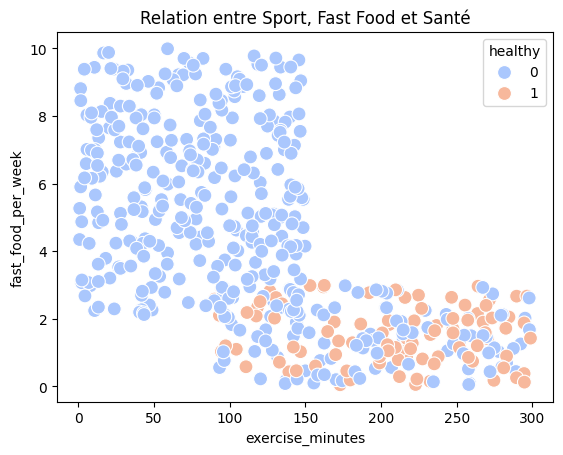

In [7]:
sns.scatterplot(data=df, x='exercise_minutes', y='fast_food_per_week', hue='healthy', palette='coolwarm', s=100)
plt.title("Relation entre Sport, Fast Food et Santé")
plt.show()

In [8]:
FEATURES = ["sleep_hours", "exercise_minutes", "screen_time_hours", "water_glasses", "fast_food_per_week"]

X = df[FEATURES].values
y = df["healthy"].values.reshape(-1, 1)

print("X shape:", X.shape)
print("y shape:", y.shape)

X shape: (500, 5)
y shape: (500, 1)


In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


In [10]:
# Standardize features 
mean = X_train.mean(axis=0)
std = X_train.std(axis=0)
# avoid zero std
std[std == 0] = 1.0

X_train_norm = (X_train - mean) / std
X_test_norm = (X_test - mean) / std

La fonction d'activation qui transforme notre sortie linéaire en probabilité (entre 0 et 1).
$$a(z) = \frac{1}{1 + e^{-z}}$$

 Fonction de Coût (Log Loss)
 $$J(w,b) = - \frac{1}{m} \sum [y \log(\hat{y}) + (1-y) \log(1-\hat{y})]$$

In [11]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def compute_loss(y_true, y_prob):
    eps = 1e-12
    y_prob = np.clip(y_prob, eps, 1 - eps)
    m = y_true.shape[0]
    return - (1/m) * np.sum(y_true * np.log(y_prob) + (1 - y_true) * np.log(1 - y_prob))

In [12]:
class LogisticRegressionScratch:
    def __init__(self, n_features):
        self.w = np.zeros((n_features, 1))
        self.b = 0.0
        self.loss_history = [] 

    def predict_prob(self, X):
        return sigmoid(X.dot(self.w) + self.b)

    def predict(self, X, threshold=0.5):
        return (self.predict_prob(X) >= threshold).astype(int)

    def fit(self, X, y, lr=0.1, epochs=1000):
        m = X.shape[0]
        for epoch in range(1, epochs + 1):

            preds = self.predict_prob(X)
            loss = compute_loss(y, preds)
            self.loss_history.append(loss)

            dz = preds - y
            dw = (1/m) * X.T.dot(dz)
            db = (1/m) * np.sum(dz)

            self.w -= lr * dw
            self.b -= lr * db

        #plt.figure(figsize=(8,5))
        plt.plot(self.loss_history, label="Training Loss")
        plt.xlabel("Itérations")
        plt.ylabel("Loss")
        plt.title("Évolution du coût pendant l’entraînement")
        plt.grid(True)
        plt.legend()
        plt.show()

        return self.w, self.b

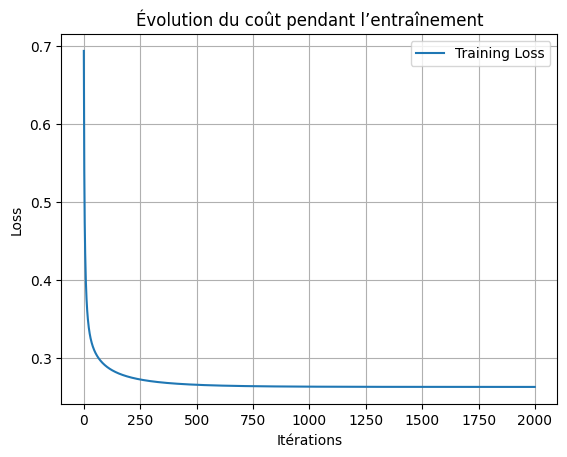

(array([[-2.89313791],
        [ 0.87518527],
        [-1.43243029],
        [ 0.77681062],
        [-1.94915055]]),
 np.float64(-4.469927726424779))

In [13]:
model = LogisticRegressionScratch(n_features=X_train_norm.shape[1])
model.fit(X_train_norm, y_train, lr=0.5, epochs=2000)

In [14]:
y_pred_test = model.predict(X_test_norm)

acc = accuracy_score(y_test, y_pred_test)*(100)
cm = confusion_matrix(y_test, y_pred_test)

print("\nTest Accuracy:", acc, '%')


Test Accuracy: 89.0 %


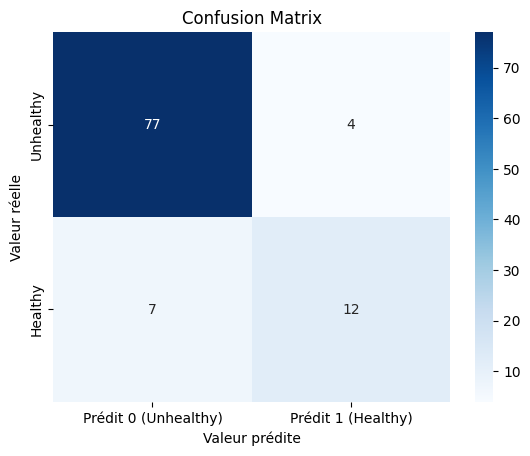

In [15]:
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Prédit 0 (Unhealthy)", "Prédit 1 (Healthy)"],
            yticklabels=["Unhealthy", "Healthy"])
plt.title("Confusion Matrix")
plt.ylabel("Valeur réelle")
plt.xlabel("Valeur prédite")
plt.show()